In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../utils/')

from LinearPerlin import *
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def load_png_as_grayscale(image_path):
    """
    Load a PNG image as a 2D numpy array in grayscale.

    - Inputs -
    image_path : path to the PNG image file

    - Outputs -
    grayscale_array : the image as a 2D numpy array in grayscale
    """
    # Load the image
    image = Image.open(image_path)
    
    # Convert the image to grayscale
    grayscale_image = image.convert("L")
    
    # Convert the grayscale image to a numpy array
    grayscale_array = np.array(grayscale_image,dtype=np.int32)
    
    return grayscale_array

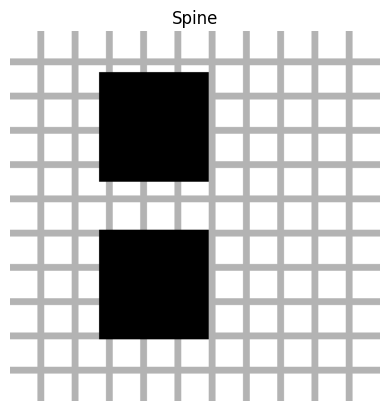

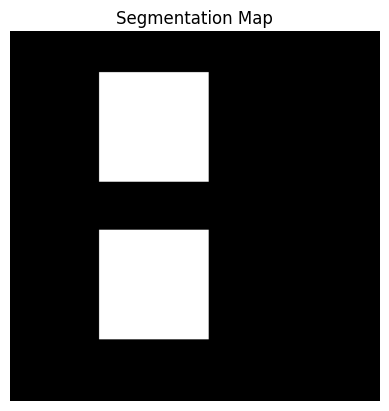

In [2]:
spine_path = './test_data/squares_high_res.png' 
spine_array = load_png_as_grayscale(spine_path)

segmentation_path = './test_data/segmap_high_res.png'
segmentation_map = load_png_as_grayscale(segmentation_path)

# Display the grayscale image
plt.imshow(spine_array, cmap='gray')
plt.title("Spine")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the grayscale image
plt.imshow(segmentation_map, cmap='gray')
plt.title("Segmentation Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

np.max(segmentation_map/255)
segmentation_map = segmentation_map

In [3]:
from LinearDeformationField import *
lin_def_field,mask,new_segmentation_map_linear = create_linear_deformation_field(segmentation_map,100)


{1: array([237.5, 356.5]), 2: array([628.5, 356.5])}


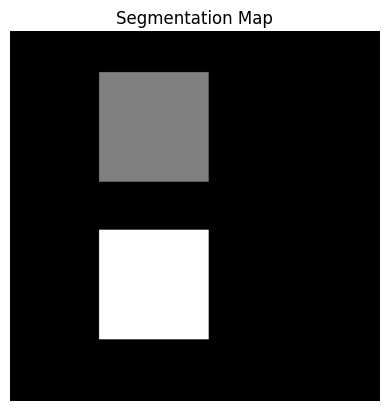

In [4]:
from Clustering import *
segmentation_map,centroids = label_connected_components(segmentation_map)

print(centroids)

# Display the grayscale image
plt.imshow(segmentation_map, cmap='gray')
plt.title("Segmentation Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

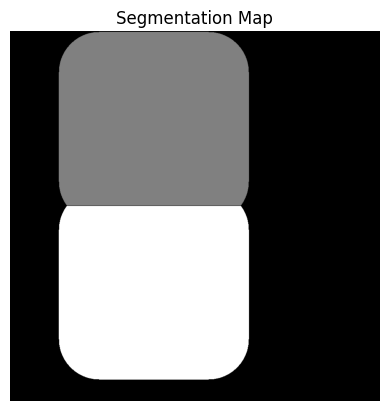

In [5]:
segmentation_map_all = color_pixels_based_on_distance(segmentation_map,100)
# Display the grayscale image
plt.imshow(segmentation_map_all, cmap='gray')
plt.title("Segmentation Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

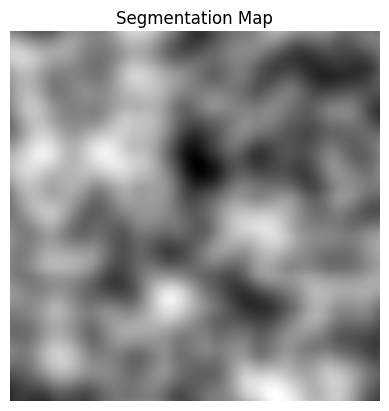

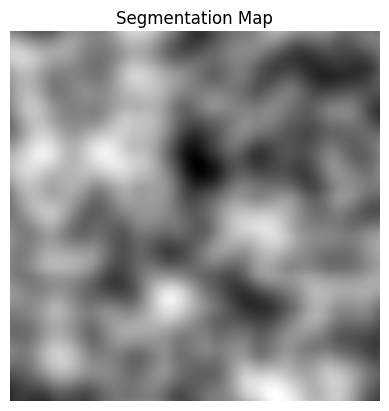

In [6]:
#load a perlin noise map
perlin_x_path = './test_data/perlin_high_res_1.png'
perlin_x = load_png_as_grayscale(perlin_x_path)
perlin_y_path = './test_data/perlin_high_res_2.png'
perlin_y = load_png_as_grayscale(perlin_y_path)

perlin_2_d = np.stack((perlin_x, perlin_y), axis=-1)

# Display the grayscale image
plt.imshow(perlin_2_d[:,:,0], cmap='gray')
plt.title("Segmentation Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

perlin_2_d = perlin_2_d-127

# Display the grayscale image
plt.imshow(perlin_2_d[:,:,0], cmap='gray')
plt.title("Segmentation Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

-26.0


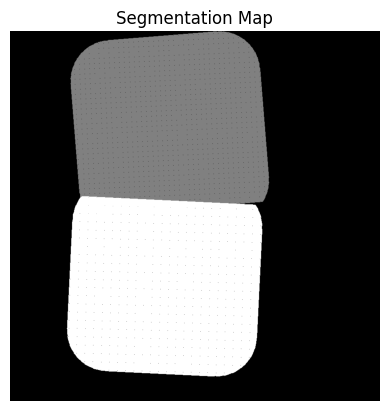

In [7]:
new_segmentation_map, deformation_field = linear_transformation_map(segmentation_map_all, centroids,use_random_seed=True)
print(np.min(deformation_field))
#new_segmentation_map = median_smoothing(new_segmentation_map)

# Display the grayscale image
plt.imshow(new_segmentation_map, cmap='gray')
plt.title("Segmentation Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [8]:
deformation_field.shape

(918, 918, 2)

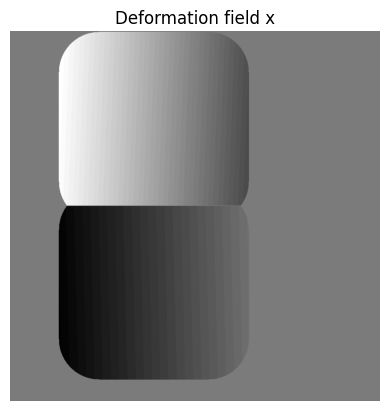

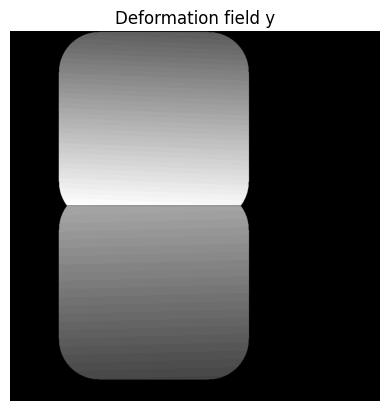

-26.0

In [9]:
# Display the grayscale image
plt.imshow(deformation_field[:,:,0], cmap='gray')
plt.title("Deformation field x")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
# Display the grayscale image
plt.imshow(deformation_field[:,:,1], cmap='gray')
plt.title("Deformation field y")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

np.min(deformation_field)

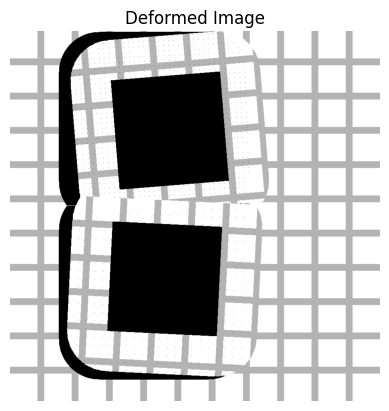

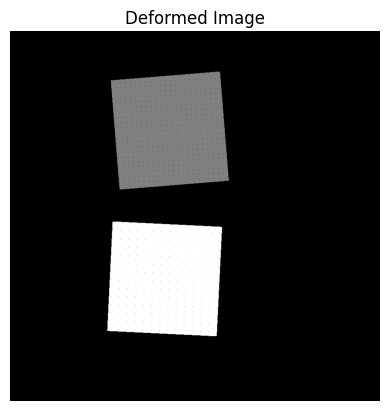

In [10]:
from scipy.ndimage import map_coordinates
import SimpleITK as sitk


def apply_deformation_field(image, deformation_field):
    H, W = image.shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    
    # Create the deformed coordinates
    deformed_X = X + deformation_field[..., 0]
    deformed_Y = Y + deformation_field[..., 1]

    # Apply the deformation field using map_coordinates
    deformed_image = map_coordinates(image, [deformed_Y, deformed_X], order=1,mode='reflect')
    
    return deformed_image

def deform_loop(image, deformation_field):
    new_image = np.zeros_like(image)
    rows,cols = image.shape
    for x in range(rows):
        for y in range(cols):
                new_x = (x + deformation_field[x,y,0]).astype(int)
                new_y = (y + deformation_field[x,y,1]).astype(int)
                if 0 <= new_x < rows and 0 <= new_y < cols:
                    new_image[new_x,new_y] = image[x,y]

    return new_image


test_def_field = './test_data/def_field.png' 
test_def_field = load_png_as_grayscale(test_def_field)
test_def_field = np.stack((test_def_field,test_def_field),axis = -1)
test_def_field = test_def_field/np.max(test_def_field)

deformed_image = deform_loop(spine_array,deformation_field)
deformed_segmentation_map = deform_loop(segmentation_map,deformation_field)
# Display the grayscale image
plt.imshow(deformed_image, cmap='gray')
plt.title("Deformed Image")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
plt.imshow(deformed_segmentation_map, cmap='gray')
plt.title("Deformed Image")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

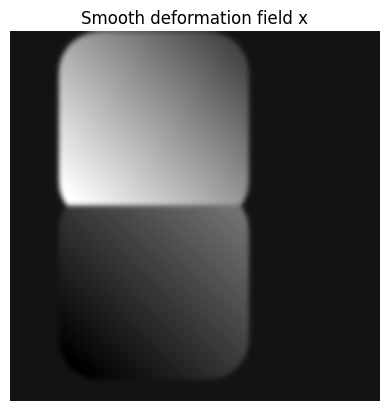

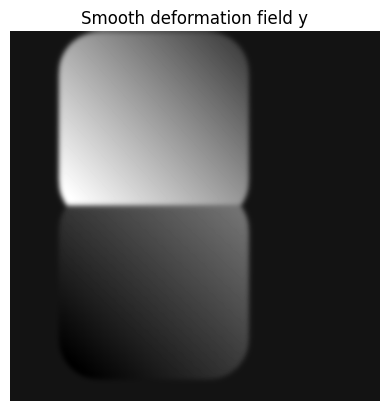

In [11]:
smooth_deformation = smooth_transitions(deformation_field,6)
# Display the grayscale image
plt.imshow(smooth_deformation[:,:,0], cmap='gray')
plt.title("Smooth deformation field x")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
# Display the grayscale image
plt.imshow(smooth_deformation[:,:,1], cmap='gray')
plt.title("Smooth deformation field y")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

(918, 918, 2)
-183.1628835009611


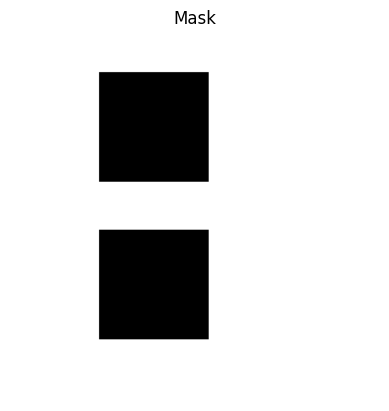

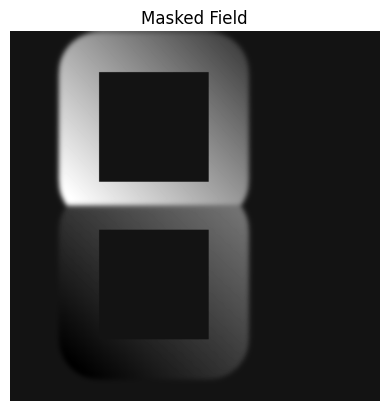

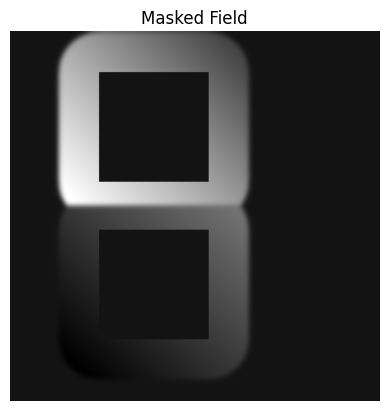

In [12]:
# apply a mask 

def invert_array(array):
    """
    Invert a 2D numpy array so that zero values become one and non-zero values become zero.
    
    Args:
    - array (numpy.ndarray): The input 2D numpy array.
    
    Returns:
    - numpy.ndarray: The inverted array.
    """
    inverted_array = (array == 0).astype(int)
    return inverted_array

mask = invert_array(segmentation_map)
print(deformation_field.shape)
masked_field = smooth_deformation * mask[:,:,np.newaxis]

#scale to same as field above
masked_field = masked_field * np.max(deformation_field)

print(np.min(masked_field))

# Display the grayscale image
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
# Display the grayscale image
plt.imshow(masked_field[:,:,0], cmap='gray')
plt.title("Masked Field")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
# Display the grayscale image
plt.imshow(masked_field[:,:,1], cmap='gray')
plt.title("Masked Field")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

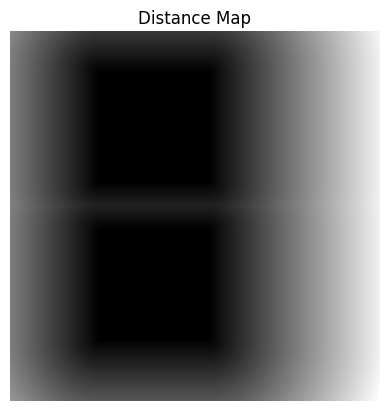

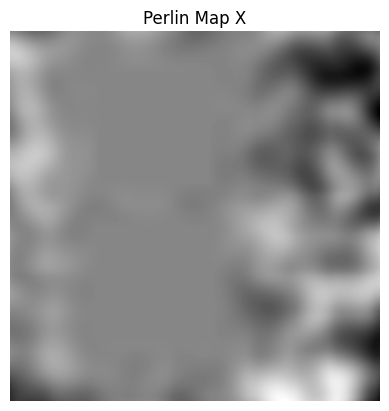

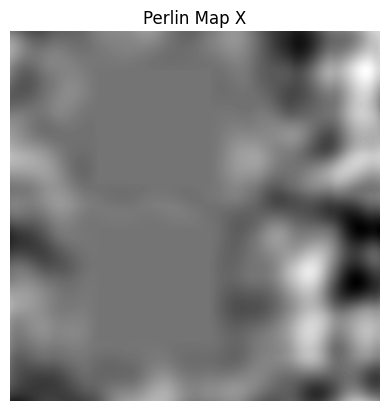

In [13]:
from scipy.ndimage import distance_transform_edt

binary_image = mask == 0

# Compute the distance transform
distance_map = distance_transform_edt(binary_image == 0)
# Display the grayscale image
plt.imshow(distance_map, cmap='gray')
plt.title("Distance Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

perlin_scaled = perlin_2_d * distance_map[:,:,np.newaxis] * mask[:,:,np.newaxis] * 0.001

# Display the grayscale image
plt.imshow(perlin_scaled[:,:,0], cmap='gray')
plt.title("Perlin Map X")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the grayscale image
plt.imshow(perlin_scaled[:,:,1], cmap='gray')
plt.title("Perlin Map X")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


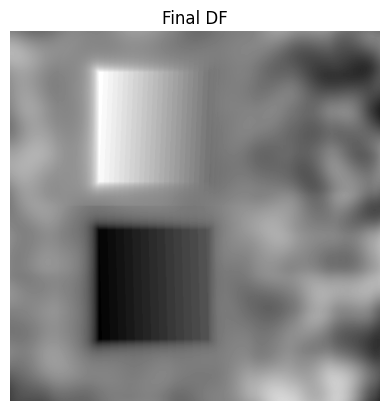

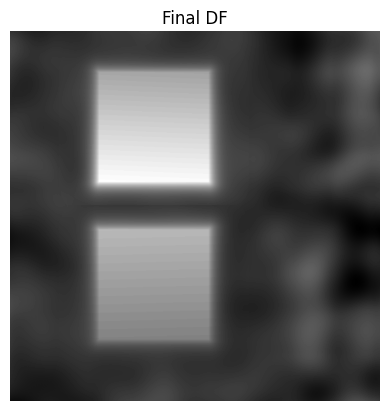

In [14]:
#now put everything together to create the new deformation_field
td_distance = np.stack((distance_map,distance_map),axis=-1)
final_deformation_field =  np.exp(-td_distance/20)*deformation_field + perlin_scaled

# Display the grayscale image
plt.imshow(final_deformation_field[:,:,0], cmap='gray')
plt.title("Final DF")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the grayscale image
plt.imshow(final_deformation_field[:,:,1], cmap='gray')
plt.title("Final DF")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

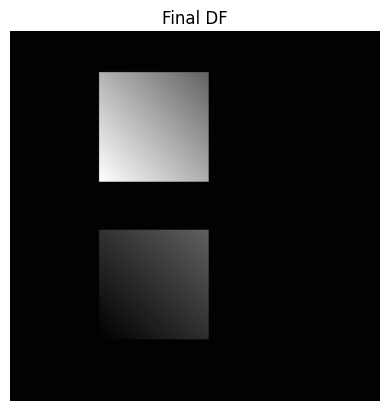

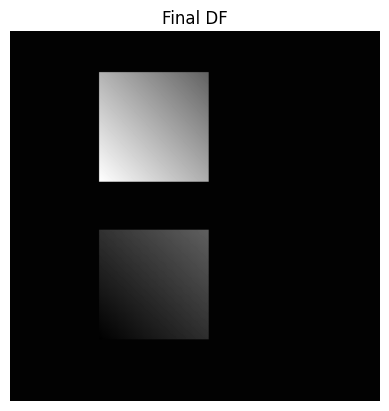

In [15]:
lin_def_field_final = lin_def_field + perlin_scaled
# Display the grayscale image
plt.imshow(lin_def_field_final[:,:,0], cmap='gray')
plt.title("Final DF")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the grayscale image
plt.imshow(lin_def_field_final[:,:,1], cmap='gray')
plt.title("Final DF")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

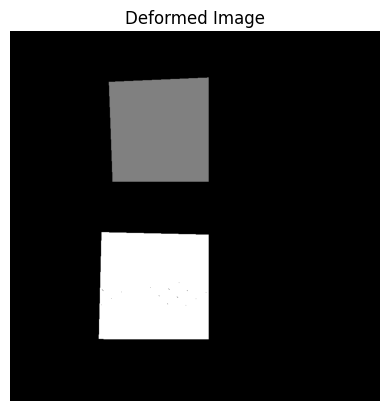

35.16311254371703

In [22]:
deformed_image = deform_loop(, lin_def_field_final)

plt.imshow(, cmap='gray')
plt.title("Deformed Image")
plt.axis('off')
plt.show()

np.max(lin_def_field_final)

In [17]:
import numpy as np
import torch
import deepali.core.functional as F
from deepali.spatial import Grid, ImageTransformer, StationaryVelocityFreeFormDeformation

def apply_deformation(image_np, deformation_field_np):
    """
    Apply a deformation field to an image using Deepali.
    
    Parameters:
    - image_np: NumPy array representing the image.
    - deformation_field_np: NumPy array representing the deformation field.
    
    Returns:
    - deformed_image_np: NumPy array representing the deformed image.
    """
    # Convert the image and deformation field to PyTorch tensors
    image_tensor = torch.tensor(image_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    deformation_field_tensor = torch.tensor(deformation_field_np, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    # Create a Grid for the deformation field
    shape = image_tensor.shape[-2:]
    grid = Grid(size=shape)
    
    # Create a StationaryVelocityFreeFormDeformation object with the deformation field
    field = StationaryVelocityFreeFormDeformation(grid, stride=1)
    field.data = deformation_field_tensor
    
    # Create an ImageTransformer
    transformer = ImageTransformer(field)
    
    # Apply the deformation to the image
    deformed_image_tensor = transformer.resample(image_tensor)
    
    # Convert the deformed image back to a NumPy array
    deformed_image_np = deformed_image_tensor.squeeze().numpy()
    
    return deformed_image_np

smooth_deformed_image = apply_deformation(spine_array,final_deformation_field)

plt.imshow(smooth_deformed_image, cmap='gray')
plt.title("Deformed Image")
plt.axis('off')
plt.show()

AttributeError: 'ImageTransformer' object has no attribute 'resample'

Now we want to test everything in 3D

In [ ]:
from ThreeDVisualizer import plot_3d
from NiftyLoader import load_nii_as_numpy

nifty_path = './test_data/segmentation_map_spine.nii.gz'
segmentation_map = load_nii_as_numpy(nifty_path)

#plot 
plot_3d(segmentation_map)

In [ ]:
segmentation_map,centroids = label_connected_components(segmentation_map)

In [ ]:
new_segmentation_map,trafo_map = linear_transformation_map(segmentation_map,centroids,max_translation_ratio=200)

In [ ]:
plt.imshow(trafo_map[10,:,:], cmap='gray')
plt.title("Segmentation Map")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

trafo_map.shape

In [ ]:
new_segmentation_map= median_smoothing(new_segmentation_map)

In [ ]:
plot_3d(new_segmentation_map)


In [ ]:
import nibabel as nib
nifty_path = './test_data/segmentation_map_spine.nii.gz'
img = nib.load(nifty_path)

voxel_spacing = img.header['pixdim'][1:4]
voxel_spacing
